# Hello Soft Clustering (GMM)

## Utility Functions

### Draw Confidence Ellipse

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

### Print Matrix Nicely

In [0]:
def matprint(mat, fmt="g"):
  col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
  for x in mat:
    for i, y in enumerate(x):
      print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
    print("")

## GMM

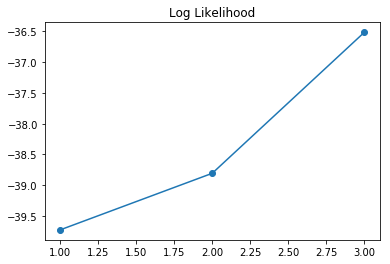

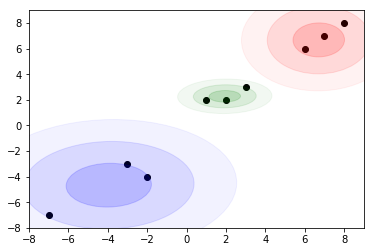

In [3]:
import numpy as np
from scipy.stats import multivariate_normal as mv_normal
import matplotlib.pyplot as plt
import math

class GMM:
  ITER_COUNT = 3

  def __init__(self, mixture_count, dim, mean, cov = None, weight = None):
    self.mixture_count = mixture_count
    if mean == None:
      pass # TODO Init mean by random
    self.mean = mean
    if cov == None:
      cov = [np.eye(dim) for i in range(mixture_count)]
    self.cov = cov
    if weight == None:
      weight = [1/mixture_count for i in range(mixture_count)]
    self.weight = weight
    self.dim = dim

  def print_step(self):
    print('Weight (m\u2c7c)')
    for i in range(self.mixture_count):
      print('\tMixture', i + 1, ':', self.weight[i])

    print('Mean (\u03bc\u2c7c)')
    for i in range(self.mixture_count):
      print('\tMixture', i + 1, ':', self.mean[i])

    print('Covariance Matrix (\u03a3\u2c7c)')
    for i in range(self.mixture_count):
      print('\tMixture', i + 1, ':')
      matprint(self.cov[i])
      # print(self.cov[i], '\n')

  def calc_gaussian_prob(self, data, gaussian_number):
    return mv_normal.pdf(data, self.mean[gaussian_number], self.cov[gaussian_number]) * self.weight[gaussian_number] \
      / sum([mv_normal.pdf(data, self.mean[i], self.cov[i]) * self.weight[i] for i in range(self.mixture_count)])
  
  def calc_likelihood(self, points):
    return sum([math.log(sum([self.weight[j] * mv_normal.pdf(points[n], self.mean[j], self.cov[j]) \
                  for j in range(self.mixture_count)])) for n in range(len(points))])

  # Expectation Step
  def E_step(self, points):
    w = []
    for n in range(len(points)):
        w.append([self.calc_gaussian_prob(points[n], j) for j in range(self.mixture_count)])
    return w

  # Maximization Step
  def M_step(self, points, gaussian_prob):
    for j in range(self.mixture_count):
      prob_sum = sum([gaussian_prob[n][j] for n in range(len(points))])
      self.weight[j] = prob_sum / len(points)
      self.mean[j] = sum([np.dot(gaussian_prob[n][j], np.array(points[n])) for n in range(len(points))]) / prob_sum
      self.cov[j] = sum([np.dot(gaussian_prob[n][j], np.array([np.array(points[n]) - np.array(self.mean[j])]).T) \
                  .dot(np.array([np.array(points[n]) - np.array(self.mean[j])])) for n in range(len(points))]) / prob_sum
      # Set off-diagonal values to zero.
      self.cov[j] = np.diag(np.diag(self.cov[j])) 

  def do_GMM(self, points, show_step = False, show_likelihood = False):
    log_likelihood = []
    for i in range(self.ITER_COUNT):
      gaussian_prob = self.E_step(points)
      self.M_step(points, gaussian_prob)
      log_likelihood.append(self.calc_likelihood(points))
      if show_step:
        print('-' * 20, 'ITER:', i + 1, '-' * 20)
        print('w\u1d62\u2c7c')
        matprint(np.array(gaussian_prob))
        self.print_step()
    if show_likelihood:
      plt.title('Log Likelihood')
      plt.plot(np.arange(1, self.ITER_COUNT + 1), log_likelihood, marker='o')
      plt.show()

    return {
        "weight": self.weight,
        "mean": self.mean,
        "cov": self.cov,
        "log_likelihood": log_likelihood
    }

def plot_GMM(points, gmm):
  ax = plt.subplot(111)
  ax.set_xlim((-8, 9))
  ax.set_ylim((-8, 9))
  color = 'rgb'
  for i in range(len(gmm['weight'])):
    x, y = np.random.multivariate_normal(gmm['mean'][i], gmm['cov'][i], 1000).T
    # plt.scatter(x, y, c=color[i], marker='.')
    confidence_ellipse(x, y, ax, edgecolor=color[i], n_std=1.0, facecolor=color[i], alpha=0.15)
    confidence_ellipse(x, y, ax, edgecolor=color[i], n_std=2.0, facecolor=color[i], alpha=0.1)
    confidence_ellipse(x, y, ax, edgecolor=color[i], n_std=3.0, facecolor=color[i], alpha=0.05)
  for pt in points:
    plt.scatter(pt[0], pt[1], c='black', marker='o')
  plt.show()

data_points = [(1, 2), (3, 3), (2, 2), (8, 8), (6, 6), 
               (7, 7), (-3, -3), (-2, -4), (-7, -7)]

gmm = GMM(3, 2, [(3, 3), (2, 2), (-3, -3)]).do_GMM(data_points, show_step = False, show_likelihood = True)
plot_GMM(data_points, gmm)

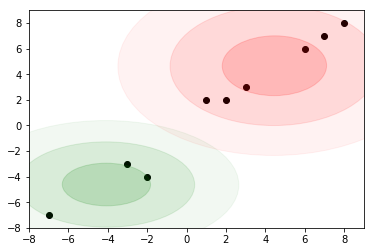

In [0]:
gmm = GMM(2, 2, [(3, 3), (-3, -3)]).do_GMM(data_points, show_step = False, show_likelihood = False)
plot_GMM(data_points, gmm)

In [0]:
gmm_3 = GMM(3, 2, [(3, 3), (2, 2), (-3, -3)]).do_GMM(data_points)
gmm_2 = GMM(2, 2, [(3, 3), (-3, -3)]).do_GMM(data_points)
plt.plot(np.arange(1, 4), gmm_3['log_likelihood'], label='3 Mixtures')
plt.plot(np.arange(1, 4), gmm_2['log_likelihood'], label='2 Mixtures')
plt.legend()
plt.show()

# The Face Database

## Load facedata

Download and unzip with command line.

In [0]:
! wget "https://github.com/ekapolc/pattern_2019/raw/master/HW/HW3/facedata_mat.zip" && unzip facedata_mat.zip

Load mat and rescale value. 

In [0]:
import scipy.io
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import img_as_float
from progressbar import progressbar

raw_data = scipy.io.loadmat("facedata.mat")['facedata']
PERSON_COUNT = 40
IMAGE_PER_PERSON = 10

data = {}
datav = {}
for i in range(len(raw_data)):
  for j in range(len(raw_data[i])):
    data[i, j] = img_as_float(raw_data[i, j])
    datav[i, j] = data[i, j].reshape(-1)

IMG_SIZE = data[0, 0].shape

print(data[2, 5])
plt.imshow(data[2, 5], cmap="gray")
plt.show()

## Tutorial

Data is a dictionary with key value pairs. The data you want to use can be
accessed by using `facedata` as the key

In [0]:
''' face data is a 2-dimensional array with size 40x10 '''
print(data[0, 0].shape)

'''
 Each data is indexed by i and j where i is the person index j is the index of the pose
 In other words, there are 40 people in the database. There are 10 images per person.
'''
print(data[0,0])

''' Each image is a 56 by 46 image '''
print(data[0,0].shape)

''' You can see the image by using the imshow in matplotlib '''
plt.imshow(data[0,0],cmap="gray")
plt.show()

Each pixel in an image is usually represented by a 8-bit unsigned integer
(values from 0 to 255). In order to easily work on images, we usually convert
them to floats or doubles using the following command.

Note that the index of a 2D image starts from the upper left corner of the
image. The first dimension goes downwards, while the second dimension goes
to the right (think of it as a matrix). To understand what this means, try the
following code

In [0]:
xf = {}
xf[0,0] = img_as_float(data[0,0])
print(xf[0,0])
plt.imshow(xf[0,0], cmap="gray")
plt.show()
x_temp = xf[0,0]
x_temp[0:5,0:10] = 1
# In float format, 1 is white
plt.imshow(x_temp, cmap="gray")
plt.show()

## The Similarity Matrix

In [0]:
# T5
print(np.linalg.norm(datav[0, 0] - datav[0, 1])) # Same person
print(np.linalg.norm(datav[0, 0] - datav[1, 0])) # Different person

10.037616294165492
8.173295099737281


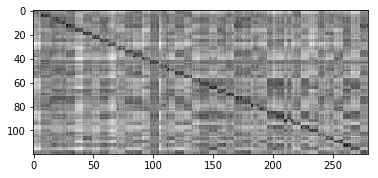

In [0]:
# T6
def gen_similar_matrix(T, D):
  res = np.zeros((len(T), len(D)), dtype=float)
  for i in range(len(T)):
    for j in range(len(D)):
      res[i, j] = np.linalg.norm(T[i] - D[j])
  return res

TRAIN_COUNT = 3
train_set = [datav[i, j] for i in range(PERSON_COUNT) for j in range(TRAIN_COUNT)]
test_set = [datav[i, j] for i in range(PERSON_COUNT) for j in range(TRAIN_COUNT, IMAGE_PER_PERSON)]
sm = gen_similar_matrix(train_set, test_set)
plt.imshow(sm, cmap='gray')
plt.show()

## Simple Face Verification System

In [0]:
# T8
def test_result(result, showTable):
  try:
    precision = result[1][1] / (result[1][1] + result[0][1])
  except ZeroDivisionError:
    precision = float('inf')
  recall = result[1][1] / (result[1][1] + result[1][0])
  try:
    fscore = 2 * precision * recall / (precision + recall)
  except ZeroDivisionError:
    fscore = float('nan')
  falseAlarm = result[0][1] / (result[0][1] + result[0][0])
  
  if showTable:
    print('             +--------------+-------------+')
    print('             | Detected Yes | Detected No |')
    print('+------------+--------------+-------------+')
    print('| Actual Yes |    %4d      |    %4d     |' % (result[1][1], result[1][0]))
    print('+------------+--------------+-------------+')
    print('| Actual No  |    %4d      |    %4d     |' % (result[0][1], result[0][0]))
    print('+------------+--------------+-------------+')

    print('Precision =', precision)
    print('Recall =', recall)
    print('F Score =', fscore)
    print()
  
  return { 'precision': precision, 'recall': recall, 'fscore': fscore, 'falseAlarm': falseAlarm }

def test_model(similarity_matrix, threshold, showTable = True):
  result = [[0, 0], [0, 0]]
  train_size, test_size = similarity_matrix.shape
  for i in range(test_size):
    for j in range(PERSON_COUNT):
      prediction = min([similarity_matrix[TRAIN_COUNT * j + k][i] for k in range(TRAIN_COUNT)]) <= threshold
      actual = (j == (i // (IMAGE_PER_PERSON - TRAIN_COUNT)))
      result[actual][int(prediction)] += 1
  return test_result(result, showTable)

test_model(sm, 10)

             +--------------+-------------+
             | Detected Yes | Detected No |
+------------+--------------+-------------+
| Actual Yes |     279      |       1     |
+------------+--------------+-------------+
| Actual No  |    4984      |    5936     |
+------------+--------------+-------------+
Precision = 0.053011590347710434
Recall = 0.9964285714285714
F Score = 0.10066750856936678



{'falseAlarm': 0.4564102564102564,
 'fscore': 0.10066750856936678,
 'precision': 0.053011590347710434,
 'recall': 0.9964285714285714}

100% (1000 of 1000) |####################| Elapsed Time: 0:00:27 Time:  0:00:27


At FAR = 0.001, Recall = 0.5428571428571428
EER = 0.0892857142857143


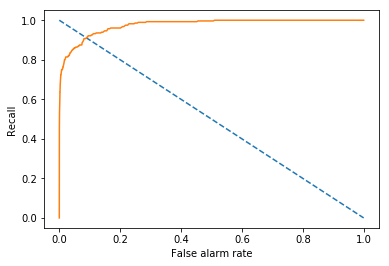

In [0]:
# T9, T10
def find_nearest(array, value):
  array = np.asarray(array)
  idx = (np.abs(array - value)).argmin()
  return idx
  
def plot_roc(similar_matrix, dim = None, THRESHOLD_COUNT = 1000, MINT = 0, MAXT = None, showGraph = True, printResult = True, showEERLine = True):
  MAXT = MAXT if MAXT != None else similar_matrix.max()
  THRESHOLD_RANGE = np.arange(MINT, MAXT, MAXT / THRESHOLD_COUNT)
  roc = []
  for t in progressbar(THRESHOLD_RANGE):
    score = test_model(similar_matrix, t, False)
    roc.append((score['falseAlarm'], score['recall']))
  roc.sort()
  falseAlarm = [x[0] for x in roc]
  recall = [x[1] for x in roc]

  eer_x = np.linspace(0, 1, 100)
  if showEERLine:
    plt.plot(eer_x, -eer_x + 1, linestyle='--')
  fnr = 1 - np.array(recall)
  nearest_idx = np.argmin(np.absolute(fnr - np.array(falseAlarm)))
  eer = (falseAlarm[nearest_idx] + fnr[nearest_idx]) / 2

  if printResult:
    print('At FAR = 0.001, Recall =', recall[find_nearest(falseAlarm, 0.001)])
    print('EER =', eer)

  if showGraph:
    plt.plot(falseAlarm, recall)
    plt.xlabel('False alarm rate')
    plt.ylabel('Recall')
    plt.show()
  
  return falseAlarm, recall, eer

plot_roc(sm, len(datav[0, 0]))
plt.show()

## Principle Component Analysis

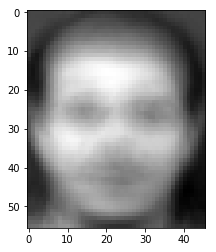

In [0]:
train_set_mat = np.array(train_set).T
train_mean = np.mean(train_set_mat, axis = 1)
plt.imshow(train_mean.reshape(IMG_SIZE), cmap='gray')
plt.show()

Find Covariance Matrix

In [0]:
# T12
train_set_mat.shape
cov = np.cov(train_set_mat)
print('Cov Size =', cov.shape)
print('Cov Rank =', np.linalg.matrix_rank(cov))

Cov Size = (2576, 2576)
Cov Rank = 119


Find Gram matrix

In [0]:
# T13, T14
train_std = train_set_mat - train_mean.reshape(-1, 1)
gram_mat = train_std.T.dot(train_std)
print('Gram Size =', gram_mat.shape)
print('Gram Rank =', np.linalg.matrix_rank(gram_mat))

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)
print('Symmetric :', check_symmetric(gram_mat))

Gram Size = (120, 120)
Gram Rank = 119
Symmetric : True


Find Eigen vector, value of Gram matrix

Eigen count: 119


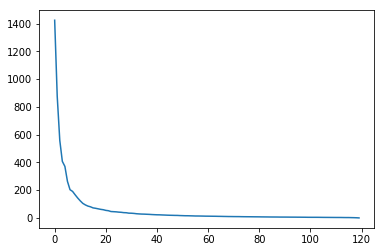

We need to use 63 eigenvectors to keep 95% of variance.


In [0]:
eig_val, eig_vec = np.linalg.eigh(gram_mat)
eig_val, eig_vec = eig_val[::-1], np.fliplr(eig_vec)

# T15
zero_count = 0
for i in range(len(eig_val)):
  if abs(eig_val[i]) < 1e-6:
    eig_val[i] = 0
    zero_count += 1

print('Eigen count:', len(eig_val) - zero_count)
plt.plot(eig_val)
plt.show()

# T16
var_sum = sum(eig_val)
c_sum = 0
for i in range(len(eig_val)):
  c_sum += eig_val[i]
  if c_sum / var_sum > 0.95:
    print('We need to use %d eigenvectors to keep 95%% of variance.' % (i,))
    break

Compute Eigen vector of covariance matrix 

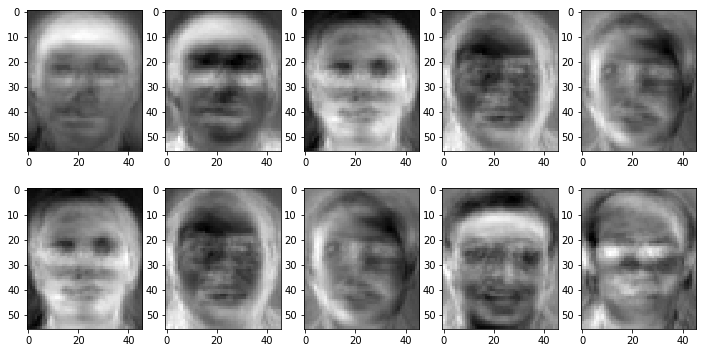

In [0]:
# T17
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
eig_vec_cov = train_std.dot(eig_vec)
for i in range(eig_vec_cov.shape[1]):
  eig_vec_cov[:,i] = eig_vec_cov[:,i] / np.linalg.norm(eig_vec_cov[:,i])
for i in range(2):
  for j in range(5):
    ax[i][j].imshow(eig_vec_cov[:,2*i+j].reshape(IMG_SIZE), cmap='gray')
plt.show()

# Cov method test
# w, v = np.linalg.eigh(np.cov(train_std))
# v = np.fliplr(v)
# v = train_sub_mean.T.dot(v)
# v = train_sub_mean.dot(v[:,:120])
# for i in range(v.shape[1]):
#   v[:,i] = v[:,i] / np.linalg.norm(v[:,i])
# fig, ax = plt.subplots(2, 5, figsize=(16, 8))
# for i in range(2):
#   for j in range(5):
#     ax[i][j].imshow(v[:,2*i+j].reshape(IMG_SIZE), cmap='gray')
# plt.show()

Find projection values.

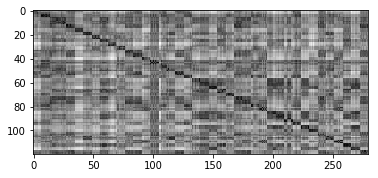

100% (1000 of 1000) |####################| Elapsed Time: 0:00:28 Time:  0:00:28


At FAR = 0.001, Recall = 0.5142857142857142
EER = 0.07870879120879123


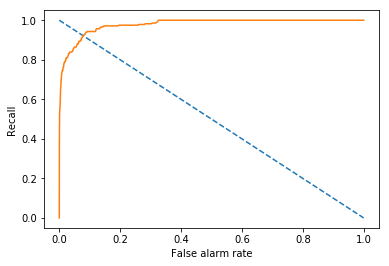

In [0]:
def k_proj_val(data_set, k):
  return [datav[:k] for datav in data_set]

def roc_k_proj_val(train_set, test_set, k, showResult = False, THRESHOLD_COUNT = 1000):
  sm_pca = gen_similar_matrix(k_proj_val(train_set_proj, k), k_proj_val(test_set_proj, k))
  if showResult:
    plt.imshow(sm_pca, cmap="gray")
    plt.show()
  return plot_roc(sm_pca, showGraph = showResult, THRESHOLD_COUNT=THRESHOLD_COUNT, showEERLine=showResult)

train_set_proj = [eig_vec_cov.T.dot(datav - train_mean) for datav in train_set]
test_set_proj = [eig_vec_cov.T.dot(datav - train_mean) for datav in test_set]

# T19
roc_k_proj_val(train_set_proj, test_set_proj, 10, showResult = True)
pass

Find the K that gives the best EER.

In [0]:
# T20
res = (1, -1)

for k in range(5, 15):
  print('\nK =', k)
  eer = roc_k_proj_val(train_set_proj, test_set_proj, k)[2]
  print('EER =', eer)
  res = min(res, (eer, k))

print('\nK = %d gives the best EER = %f' % res[::-1])

## PCA Reconstruction

In [0]:
def reconstruct_proj(proj, k):
  return train_mean.reshape(-1, 1) + eig_vec_cov[:,:k].dot(np.array(k_proj_val(proj, k)).reshape(-1, 1))

def MSE(va, vb):
  return  ((np.array(va) - np.array(vb)) ** 2).mean()

# OT1
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Original Image
original_img = train_set[0]
ax[0].imshow(original_img.reshape(IMG_SIZE), cmap='gray')
ax[0].set_title('Original')

# Reconstructed Image
reconstructed_img = reconstruct_proj([train_set_proj[0]], 10)
ax[1].imshow(reconstructed_img.reshape(IMG_SIZE), cmap= 'gray')
ax[1].set_title('Reconstructed')

plt.subplots_adjust(wspace=0.4)
plt.show()

print('MSE =', MSE(original_img, reconstructed_img))

In [0]:
# OT2
fig, ax = plt.subplots(2, 6, figsize=(16, 7))
K_LIST = tuple(range(1, 11)) + (118, 119)

for i in range(len(K_LIST)):
  res = reconstruct_proj([train_set_proj[0]], K_LIST[i])
  ax[i // 6, i % 6].set_title('K = %d' % K_LIST[i])
  ax[i // 6, i % 6].imshow(res.reshape(IMG_SIZE), cmap='gray')

plt.show()

In [0]:
mse_values = []
for k in progressbar(range(1, 120)):
  mse_values.append(MSE(reconstruct_proj([train_set_proj[0]], k), original_img))
plt.plot(mse_values)
plt.title('Mean Squared Error')
plt.show()

## Linear Discriminant Analysis

There are 120 non-zero eigenvalues


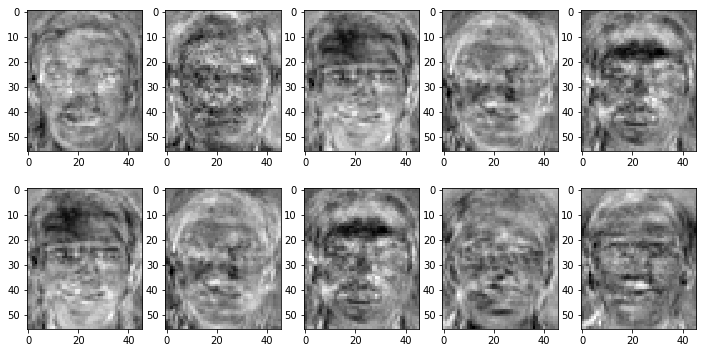

In [0]:
def within_scatter(train_set_proj):
  dim = len(train_set_proj[0])
  s = np.zeros((dim, dim))
  for i in range(PERSON_COUNT):
    class_mean = np.mean(np.array(train_set_proj[TRAIN_COUNT * i:TRAIN_COUNT * (i + 1)]), axis=0)
    for j in range(TRAIN_COUNT * i, TRAIN_COUNT * (i + 1)):
      diff = (train_set_proj[j] - class_mean).reshape(-1, 1)
      s += diff.dot(diff.T)
  return s

def between_scatter(train_set_proj):
  dim = len(train_set_proj[0])
  s = np.zeros((dim, dim))
  global_mean = np.mean(train_set_proj, axis=0)
  for i in range(PERSON_COUNT):
    class_mean = np.mean(np.array(train_set_proj[TRAIN_COUNT * i:TRAIN_COUNT * (i + 1)]), axis=0)
    diff = (class_mean - global_mean).reshape(-1, 1)
    s += diff.dot(diff.T)
  return s

pre_lda = np.linalg.inv(within_scatter(train_set_proj)).dot(between_scatter(train_set_proj))
eig_val_lda, eig_vec_lda = np.linalg.eigh(pre_lda)
eig_val_lda, eig_vec_lda = eig_val_lda[::-1], np.fliplr(eig_vec_lda)

zero_count = 0
for i in range(len(eig_val_lda)):
  if abs(eig_val_lda[i]) < 1e-6:
    eig_val_lda[i] = 0
    zero_count += 1
print('There are %d non-zero eigenvalues' % (len(eig_val_lda) - zero_count))

fisherfaces = eig_vec_cov.dot(eig_vec_lda)
for i in range(fisherfaces.shape[1]):
  fisherfaces[:,i] = fisherfaces[:,i] / np.linalg.norm(fisherfaces[:,i])

fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(2):
  for j in range(5):
    ax[i][j].imshow(fisherfaces[:,2*i+j].reshape(IMG_SIZE), cmap='gray')
plt.show()

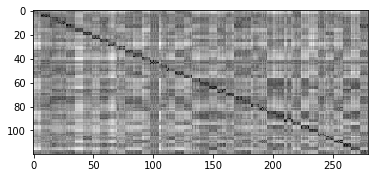

100% (2000 of 2000) |####################| Elapsed Time: 0:00:55 Time:  0:00:55


At FAR = 0.001, Recall = 0.6428571428571429
EER = 0.07032967032967032


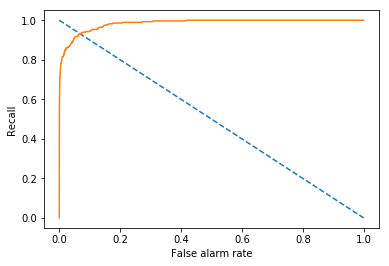

In [0]:
train_set_fisher = [fisherfaces.T.dot(datav - train_mean) for datav in train_set]
test_set_fisher = [fisherfaces.T.dot(datav - train_mean) for datav in test_set]
sm_fisher = gen_similar_matrix(train_set_fisher, test_set_fisher)
plt.imshow(sm_fisher, cmap='gray')
plt.show()
plot_roc(sm_fisher, showGraph = True, THRESHOLD_COUNT=2000)
plt.show()

Compare RoC of three methods

In [0]:
num_threshold = 1000
print('\nNo Projection')
falseAlarm_noproj, recall_noproj, eer_noproj = plot_roc(sm, showGraph = False, THRESHOLD_COUNT=num_threshold, showEERLine = False)
print('\nPCA')
falseAlarm_proj, recall_proj, eer_proj = roc_k_proj_val(train_set_proj, test_set_proj, 10, showResult = False, THRESHOLD_COUNT=num_threshold)
print('\nFisher')
falseAlarm_fisher, recall_fisher, eer_fisher = plot_roc(sm_fisher, showGraph = False, THRESHOLD_COUNT=num_threshold, showEERLine = False)

plt.figure(figsize=(7,7))
plt.xlabel('False Alarm Rate')
plt.ylabel('Recall')
plt.plot(falseAlarm_noproj, recall_noproj, label='No Projection')
plt.plot(falseAlarm_proj, recall_proj, label='PCA')
plt.plot(falseAlarm_fisher, recall_fisher, label='Fisher')
plt.legend()
plt.show()

Observe LDA plot vs PCA plot

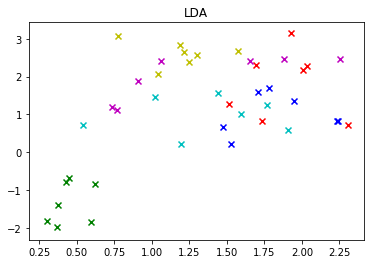

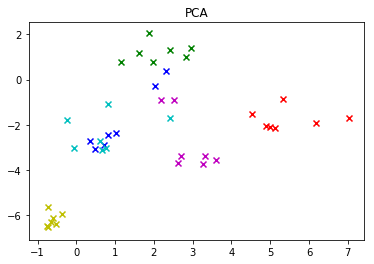

(120,) (120,)


In [0]:
COLORS = 'rgbcmyk'

# LDA
plt.title('LDA')
for i in range(0, 6 * (IMAGE_PER_PERSON - TRAIN_COUNT)):
  plt.scatter(test_set_fisher[i][0], test_set_fisher[i][1], c=COLORS[i // (IMAGE_PER_PERSON - TRAIN_COUNT)], marker='x')
plt.show()

# PCA
plt.title('PCA')
for i in range(0, 6 * (IMAGE_PER_PERSON - TRAIN_COUNT)):
  plt.scatter(test_set_proj[i][0], test_set_proj[i][1], c=COLORS[i // (IMAGE_PER_PERSON - TRAIN_COUNT)], marker='x')
plt.show()

print(test_set_fisher[0].shape, test_set_proj[0].shape)

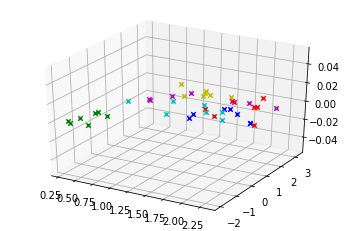

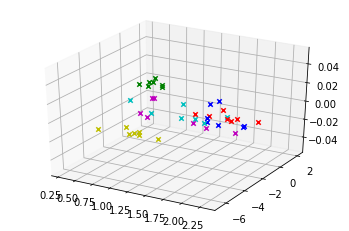

In [0]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(0, 6 * (IMAGE_PER_PERSON - TRAIN_COUNT)):
  ax.scatter(test_set_fisher[i][0], test_set_fisher[i][1], c=COLORS[i // (IMAGE_PER_PERSON - TRAIN_COUNT)], marker='x')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(0, 6 * (IMAGE_PER_PERSON - TRAIN_COUNT)):
  ax.scatter(test_set_fisher[i][0], test_set_proj[i][1], c=COLORS[i // (IMAGE_PER_PERSON - TRAIN_COUNT)], marker='x')
plt.show()